# Plotting example with pyugrid and cartopy

In [1]:
%matplotlib inline

import warnings

import numpy as np
import matplotlib.tri as tri
import matplotlib.pyplot as plt

import iris
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import pyugrid

print('pyugrid version: {}'.format(pyugrid.__version__))
print('iris version: {}'.format(iris.__version__))

pyugrid version: 0.1.7
iris version: 1.9.1


### FVCOM example

In [2]:
url = ('http://comt.sura.org/thredds/dodsC/data/comt_1_archive/inundation_tropical/'
       'VIMS_SELFE/Hurricane_Rita_2D_final_run_without_waves')

ugrid = pyugrid.UGrid.from_ncfile(url)

## Parse mesh

In [3]:
lon = ugrid.nodes[:, 0]
lat = ugrid.nodes[:, 1]
faces = ugrid.faces[:]

triang = tri.Triangulation(lon, lat, triangles=faces)

## Read data with iris

In [4]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cubes = iris.load_raw(url)

print(cubes)

0: maximum_free_surface_elevation / (m) (-- : 592761)
1: latitude / (degrees)                (-- : 592761)
2: depth_below_geoid / (m)             (-- : 592761)
3: wist.62 / (1)                       (time: 1008; -- : 592761)
4: sea_surface_height_above_geoid / (m) (time: 1008; -- : 592761)
5: barotropic_eastward_sea_water_velocity / (m/s) (time: 1008; -- : 592761)
6: Function C(s) at whole levels / (unknown) (S coordinates at whole levels: 2)
7: longitude / (degrees)               (-- : 592761)
8: barotropic_northward_sea_water_velocity / (m/s) (time: 1008; -- : 592761)
9: Horizontal Triangular Element Table / (unknown) (-- : 3; -- : 1166747)
10: wind.62 / (1)                       (time: 1008; -- : 592761)


## Last time step

In [5]:
u = cubes.extract_strict('barotropic_eastward_sea_water_velocity')[-1, ...]
v = cubes.extract_strict('barotropic_northward_sea_water_velocity')[-1, ...]

## Vector plot

In [6]:
def make_map(projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(8, 6),
                           subplot_kw=dict(projection=projection))
    ax.coastlines(resolution='50m', zorder=1)
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

/home/filipe/miniconda3/envs/IOOS/lib/python2.7/site-packages/matplotlib/artist.py:221: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)


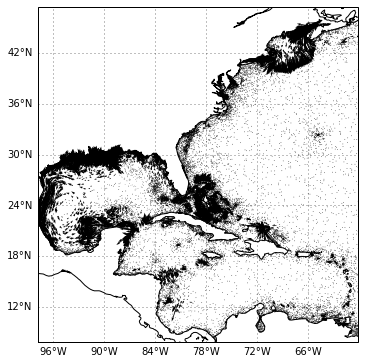

In [7]:
fig, ax = make_map()
ax.set_extent([lon.min(), lon.max(), lat.min(), lat.max()])

sub = 10
Q = ax.quiver(lon[::sub], lat[::sub],
              u[::sub].data, v[::sub].data,
              scale=4, scale_units='inches')

## I guess `streamplot` does not play nice with masked arrays :-(

/home/filipe/miniconda3/envs/IOOS/lib/python2.7/site-packages/numpy/ma/core.py:809: RuntimeWarning: invalid value encountered in greater_equal
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)


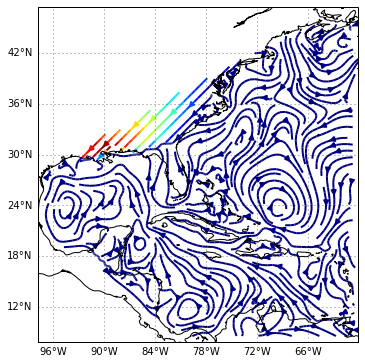

In [8]:
fig, ax = make_map()
ax.set_extent([lon.min(), lon.max(), lat.min(), lat.max()])

magnitude = (u ** 2 + v ** 2) ** 0.5
st = ax.streamplot(lon[::sub], lat[::sub],
                   u[::sub].data, v[::sub].data,
                   linewidth=2, density=2, color=magnitude[::sub].data)